In [9]:
!pip3 install tensorflow-addons

In [72]:
from collections import defaultdict
import random
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.optimizers.schedules import CosineDecay

In [11]:
input_shape = (27,27,3)
target_size = 27  # Resize the input images.
representation_dim = 128  # The dimensions of the features vector.
projection_units = 32  # The projection head of the representation learner.
num_clusters = 8  # Number of clusters.
k_neighbours = 4  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [12]:
from PIL import Image
import numpy as np
classes = ["epithelial","fibroblast","inflammatory","others"]
def load_data(labelNames, root):    
    images = list()
    labels = list()
    
    for label in labelNames:
        # get image directory
        img_dir = os.path.join(root, f"{label}")
        
        for img in os.listdir(img_dir):
            img = np.array(Image.open(os.path.join(img_dir, img),'r'))
            images.append(img)
            labels.append(label)
        
    return (images, labels)
multiclass_path = "Image_classification_data/multi-task"
images, labels = load_data(classes, multiclass_path)
images = np.asarray(images)
labels = np.asarray(labels)
print(images.shape)
print(labels.shape)

(9896, 27, 27, 3)
(9896,)


In [13]:
x_train = images

In [14]:
import keras
from keras import layers
data_preprocessing = keras.Sequential(
    [
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_train)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)

In [16]:
from sklearn.preprocessing import LabelEncoder
coder = LabelEncoder()
y = coder.fit_transform(labels)
y.shape

(9896,)

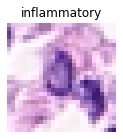

In [17]:
image_idx = np.random.choice(range(x_train.shape[0]))
image = x_train[image_idx]
image_class = classes[y[image_idx]]
plt.figure(figsize=(2, 2))
plt.imshow(x_train[image_idx].astype("uint8"))
plt.title(image_class)
_ = plt.axis("off")

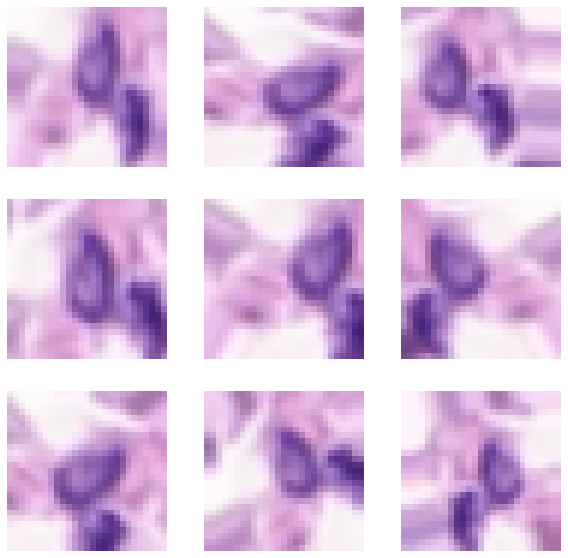

In [18]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Vision Encoder

In [74]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
    Conv2D(32, (3, 3), strides=1,activation="relu", input_shape=[27, 27, 3], padding="same"),
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    MaxPooling2D(pool_size=(2, 2), strides=2),
    
    # Convolutional layers (filter the image with a kernel)
    Conv2D(16, (3, 3),strides=1, activation="relu", padding="same"),
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    MaxPooling2D(pool_size=(2, 2),strides=2),
    
    # Flatten input
    Flatten(),
    Dense(128, activation="relu"),
    Dense(representation_dim)
        ]
    )
    encoder.summary()
    return encoder

In [20]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [21]:
import tensorflow_addons as tfa

# Create vision encoder.
encoder = create_encoder(representation_dim)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 128)              

# Representation Learner

In [108]:
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=x_train,
    batch_size=512,
    epochs=250,  # for better results, increase the number of epochs to 500.
)

Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - 14s 578ms/step - loss: 67.4614
Epoch 2/250
20/20 [==============================] - 10s 515ms/step - loss: 29.7228
Epoch 3/250
20/20 [==============================] - 10s 505ms/step - loss: 18.7413
Epoch 4/250
20/20 [==============================] - 11s 553ms/step - loss: 14.0899
Epoch 5/250
20/20 [=======================

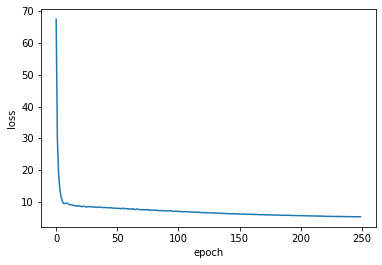

In [109]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [163]:
encoder.save_weights("encoder.h5")

In [22]:
encoder.load_weights("results/encoder.h5")

In [24]:
import tensorflow as tf
batch_size = 500
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_train, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

20/20 [==============================] - 2s 121ms/step


In [54]:
import pandas as pd
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
print(num_batches)
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours+2, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])
print(len(neighbours))
neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))
neighbours.shape

19


100%|██████████| 19/19 [00:00<00:00, 20.34it/s]

19


(11875, 4)

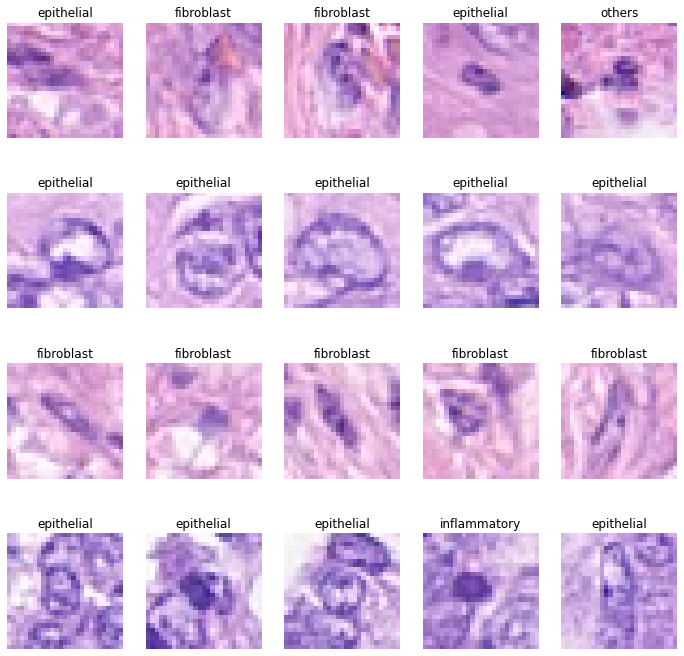

In [27]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_train.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_train[indices[j]].astype("uint8"))
        plt.title(classes[y[indices[j]]])
        plt.axis("off")
        position += 1

In [118]:
representation_learner.save_weights("representation_learner.h5")

# Semantic Clustering 

In [28]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super(ClustersConsistencyLoss, self).__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)

In [29]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super(ClustersEntropyLoss, self).__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss

In [30]:
def create_clustering_model(encoder, num_clusters, name=None):
    input_shape=(27,27,3)

    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [31]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

In [57]:
neighbours= neighbours[:x_train.shape[0]]


In [58]:
tf.gather(x_train,neighbours).shape

TensorShape([9896, 4, 27, 27, 3])

In [59]:
x_train.shape

(9896, 27, 27, 3)

In [61]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": x_train, "neighbours": tf.gather(x_train, neighbours)}
labels = tf.ones(shape=(x_train.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=512, epochs=50)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - 12s 479ms/step - loss: 0.6326 - similarity_loss: 0.6326 - clustering_loss: 4.7357e-05
Epoch 2/50
20/20 [==============================] - 10s 486ms/step - loss: 0.6326 - similarity_loss: 0.6326 - clustering_loss: 2.4374e-06
Epoch 3/50
20/20 [==============================] - 11s 530ms/step - loss: 0.6326 - similarity_loss: 0

# Cluster analysis

In [62]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_train, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - 2s 92ms/step


In [63]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 485
cluster 1 : 525
cluster 2 : 2978
cluster 3 : 571
cluster 4 : 1259
cluster 5 : 395
cluster 6 : 1746
cluster 7 : 1937


## Visualize cluster images

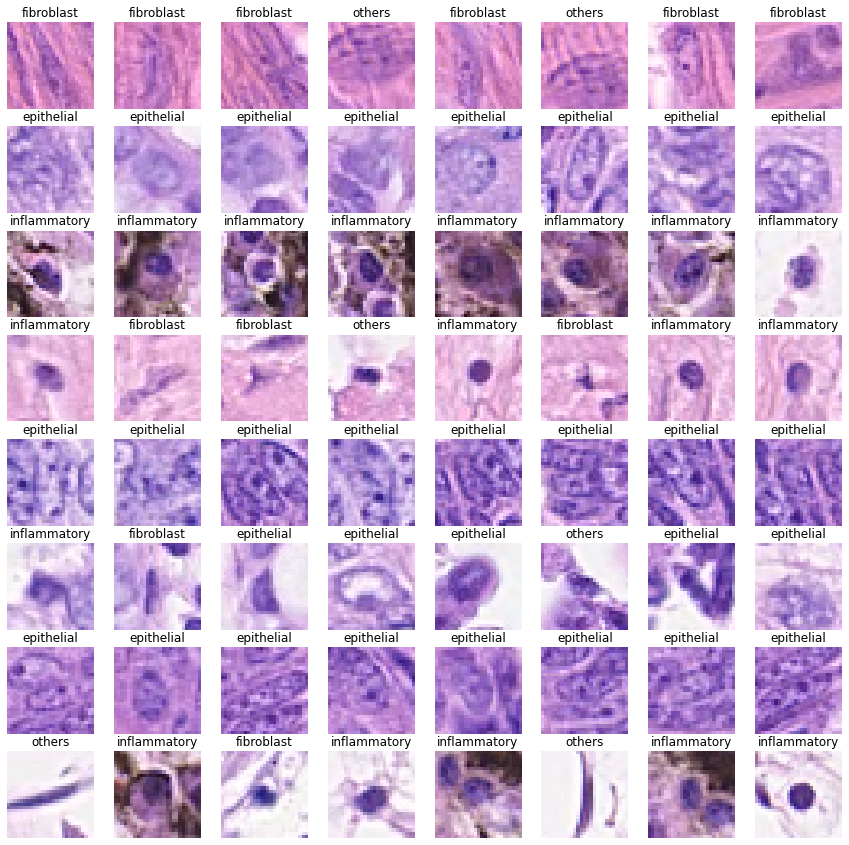

In [66]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(x_train[image_idx].astype("uint8"))
        plt.title(classes[y[image_idx]])
        plt.axis("off")
        position += 1

## Compute clustering accuracy

In [68]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * len(classes)
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][y[i]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")

cluster 0 label is: epithelial  -  accuracy: 79.18 %
cluster 1 label is: epithelial  -  accuracy: 72.38 %
cluster 2 label is: inflammatory  -  accuracy: 49.16 %
cluster 3 label is: fibroblast  -  accuracy: 33.27 %
cluster 4 label is: epithelial  -  accuracy: 85.07 %
cluster 5 label is: epithelial  -  accuracy: 49.87 %
cluster 6 label is: epithelial  -  accuracy: 83.79 %
cluster 7 label is: fibroblast  -  accuracy: 38.0 %


# Disregard unknown class

In [69]:
main_images, labels = load_data(["inflammatory","fibroblast","epithelial"], root="Image_classification_data/multi-task")


In [106]:
len(main_images)

8510

In [70]:
x_train = np.array(main_images)
y = np.array(labels)

In [75]:

# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=x_train,
    batch_size=128,
    epochs=100,  # for better results, increase the number of epochs to 500.
)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
67/67 [==============================] - 7s 77ms/step - loss: 19.9088
Epoch 2/100
67/67 [==============================] - 5s 71ms/step - loss: 10.0807
Epoch 3/100
67/67 [==============================] - 5s 75ms/step - loss: 8.0980
Epoch 4/100
67/67 [==============================] - 5s 72ms/step - loss: 6.9040
Epoch 5/100
67/67 [==============================] -

## Create representation space

In [76]:
import tensorflow as tf
batch_size = 128
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_train, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

67/67 [==============================] - 2s 26ms/step


In [108]:
import pandas as pd
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
print(num_batches)
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours+2, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])
print(len(neighbours))
neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))
neighbours.shape

66


100%|██████████| 66/66 [00:00<00:00, 72.92it/s]

66


(10560, 4)

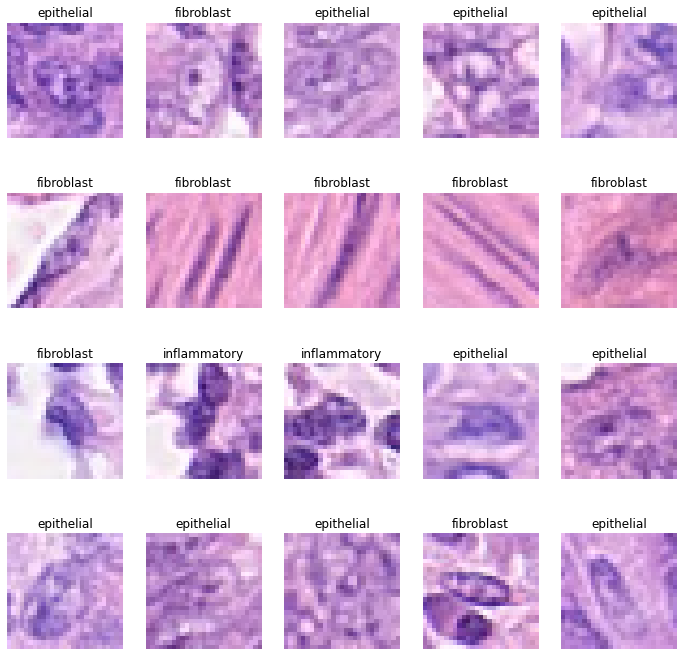

In [102]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_train.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_train[indices[j]].astype("uint8"))
        plt.title(y[indices[j]])
        plt.axis("off")
        position += 1

## Train clustering

In [118]:
all_train, labels = load_data(["inflammatory","fibroblast","epithelial","others"], root="Image_classification_data/multi-task")

In [98]:
all_train = np.array(all_train)

In [99]:
all_train.shape

(9896, 27, 27, 3)

In [109]:
neighbours = neighbours[:x_train.shape[0]]

In [110]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
num_clusters = 4
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": x_train, "neighbours": tf.gather(x_train, neighbours)}
labels = tf.ones(shape=(x_train.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=128, epochs=50)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
67/67 [==============================] - 13s 159ms/step - loss: 0.5759 - similarity_loss: 0.5759 - clustering_loss: 6.3674e-06
Epoch 2/50
67/67 [==============================] - 11s 166ms/step - loss: 0.5759 - similarity_loss: 0.5759 - clustering_loss: 2.9438e-06
Epoch 3/50
67/67 [==============================] - 12s 180ms/step - loss: 0.5759 - similarity_loss: 0

## Predict 4 classes

In [ ]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(all_train, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

## Visualize the clusters

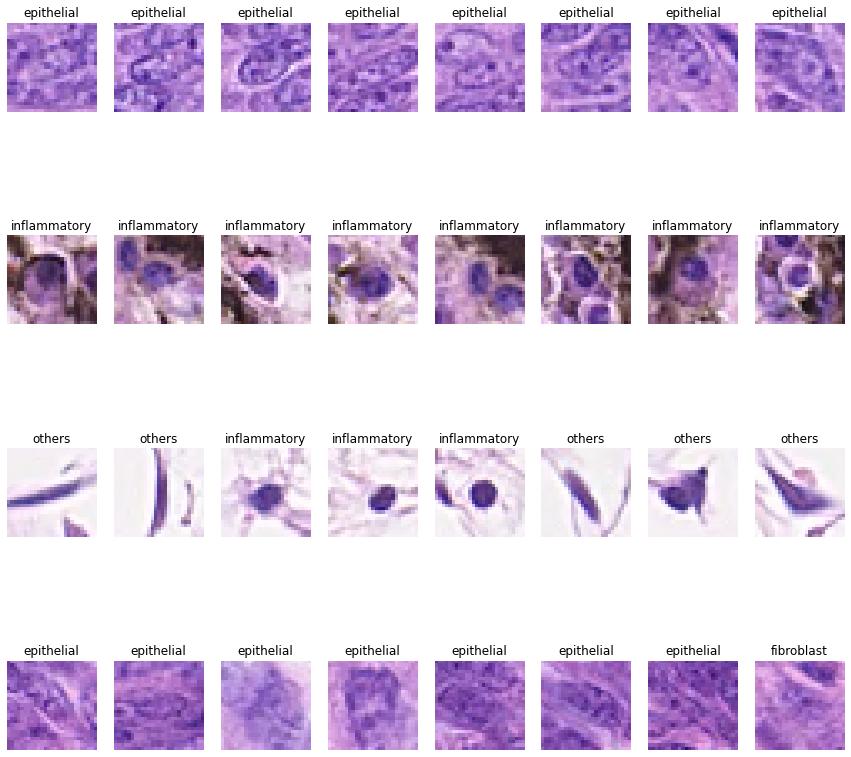

In [120]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(all_train[image_idx].astype("uint8"))
        plt.title(labels[image_idx])
        plt.axis("off")
        position += 1

## Clustering Accuracy

In [125]:
cluster_label_counts = dict()
num_clusters = 4
classes = ["inflammatory","fibroblast","epithelial","others"]
y = coder.fit_transform(labels)
for c in range(num_clusters):
    cluster_label_counts[c] = [0] * 4
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][y[i]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")

cluster 0 label is: inflammatory  -  accuracy: 81.93 %
cluster 1 label is: fibroblast  -  accuracy: 44.34 %
cluster 2 label is: epithelial  -  accuracy: 51.93 %
cluster 3 label is: inflammatory  -  accuracy: 77.2 %


In [128]:
clustering_model.save_weights("clustering_model_Train3.h5")